# Testing the Random Forest Classifier on the GBM Dataset  
In this notebook, I applied the Random Forest classifier—previously trained in `Random_Forest_training.ipynb` and saved to disk—to the GBM dataset. Additionally, I evaluated the results by identifying the most important genes for each class.

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad

from sklearn.model_selection import train_test_split
import sklearn.preprocessing as pp
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from scipy.sparse import issparse
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.metrics import classification_report

In [2]:
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(7, 4))
sc.settings.verbosity = 3

-----
anndata     0.10.8
scanpy      1.10.1
-----
PIL                         10.2.0
anyio                       NA
arrow                       1.3.0
asciitree                   NA
asttokens                   NA
astunparse                  1.6.3
attr                        23.1.0
attrs                       23.1.0
babel                       2.11.0
bottleneck                  1.3.7
brotli                      1.0.9
certifi                     2024.08.30
cffi                        1.16.0
charset_normalizer          2.0.4
cloudpickle                 3.0.0
colorama                    0.4.6
comm                        0.2.1
cycler                      0.10.0
cython_runtime              NA
dask                        2024.7.0
dateutil                    2.8.2
debugpy                     1.6.7
decorator                   5.1.1
defusedxml                  0.7.1
executing                   0.8.3
fastjsonschema              NA
fqdn                        NA
h5py                        3.9.0
id

#### Importing all required resources: the test dataset, the previously selected genes, and the model with the useful components.

In [3]:
test = sc.read_h5ad(
    '/hpc/hers_basak/rnaseq_data/Silettilab/proj/GBM/output/data/GBM_Tumor_Dissociation.h5ad')

In [4]:
selectedGenes = np.loadtxt(
    '/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/final_useful_datasets/RF_selected_genes.txt', 
    dtype=str)

In [5]:
x_train = joblib.load('/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/final_useful_datasets/models/RF_x_train.joblib')
x_test = joblib.load('/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/final_useful_datasets/models/RF_x_test.joblib')

In [6]:
y_train = joblib.load('/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/final_useful_datasets/models/RF_y_train.joblib')
y_test = joblib.load('/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/final_useful_datasets/models/RF_y_test.joblib')

In [7]:
scaler = joblib.load('/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/final_useful_datasets/models/RF_scaler.joblib')
classifier = joblib.load('/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/final_useful_datasets/models/RF.joblib')

## Step 1: Initial adjustments

#### I updated the index of `test.var` by replacing ensemble IDs with gene names, and filtered it to include only the genes selected in the training notebook.

In [8]:
test.var = (
    test.var
    .reset_index()                      
    .rename(columns={'index': 'ensemble_ids'})  
    .set_index('Gene')                  
)

test.var.index = test.var.index.astype(str)
test.var_names_make_unique(join="_")

test = test[:, selectedGenes]

/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/miniconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:767: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['marker-DsRed', 'marker-Cherry', 'marker-GFP', 'marker-Tomato', 'marker-cre']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


## Step 2: testing of the model

#### normalization by row.

In [9]:
sc.pp.normalize_total(test, target_sum=1e4)

/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/miniconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


#### I extracted the data and their labels into numpy arrays.

In [10]:
dataMatrix = test.X.copy()
expected_classes = classifier.classes_

#### I logarithmized and scaled the data with the same parameters of the training datasets and generated the predictions.

In [11]:
X_log1p = np.log1p(dataMatrix.toarray())
X_scaled = scaler.transform(X_log1p)
predicted40 = classifier.predict(X_scaled)
pred_prob_40 = classifier.predict_proba(X_scaled)

In [12]:
test.obs['predictions_RF'] = predicted40
max_probabilities = np.max(pred_prob_40, axis=1)
test.obs['max_probability_RF'] = max_probabilities

#### I saved the predictions into a dataframe.

In [13]:
test.obs[['predictions_RF', 'max_probability_RF']].to_csv('/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/final_useful_datasets/random_forest_predictions.csv')

## Step 4: evaluation of the results.

#### This code creates a grid of UMAP scatter plots where each subplot highlights cells predicted as a specific expected class against a light gray background of all cells. It then hides any unused subplots, adds a legend to the figure, adjusts the layout, and displays the final plot.

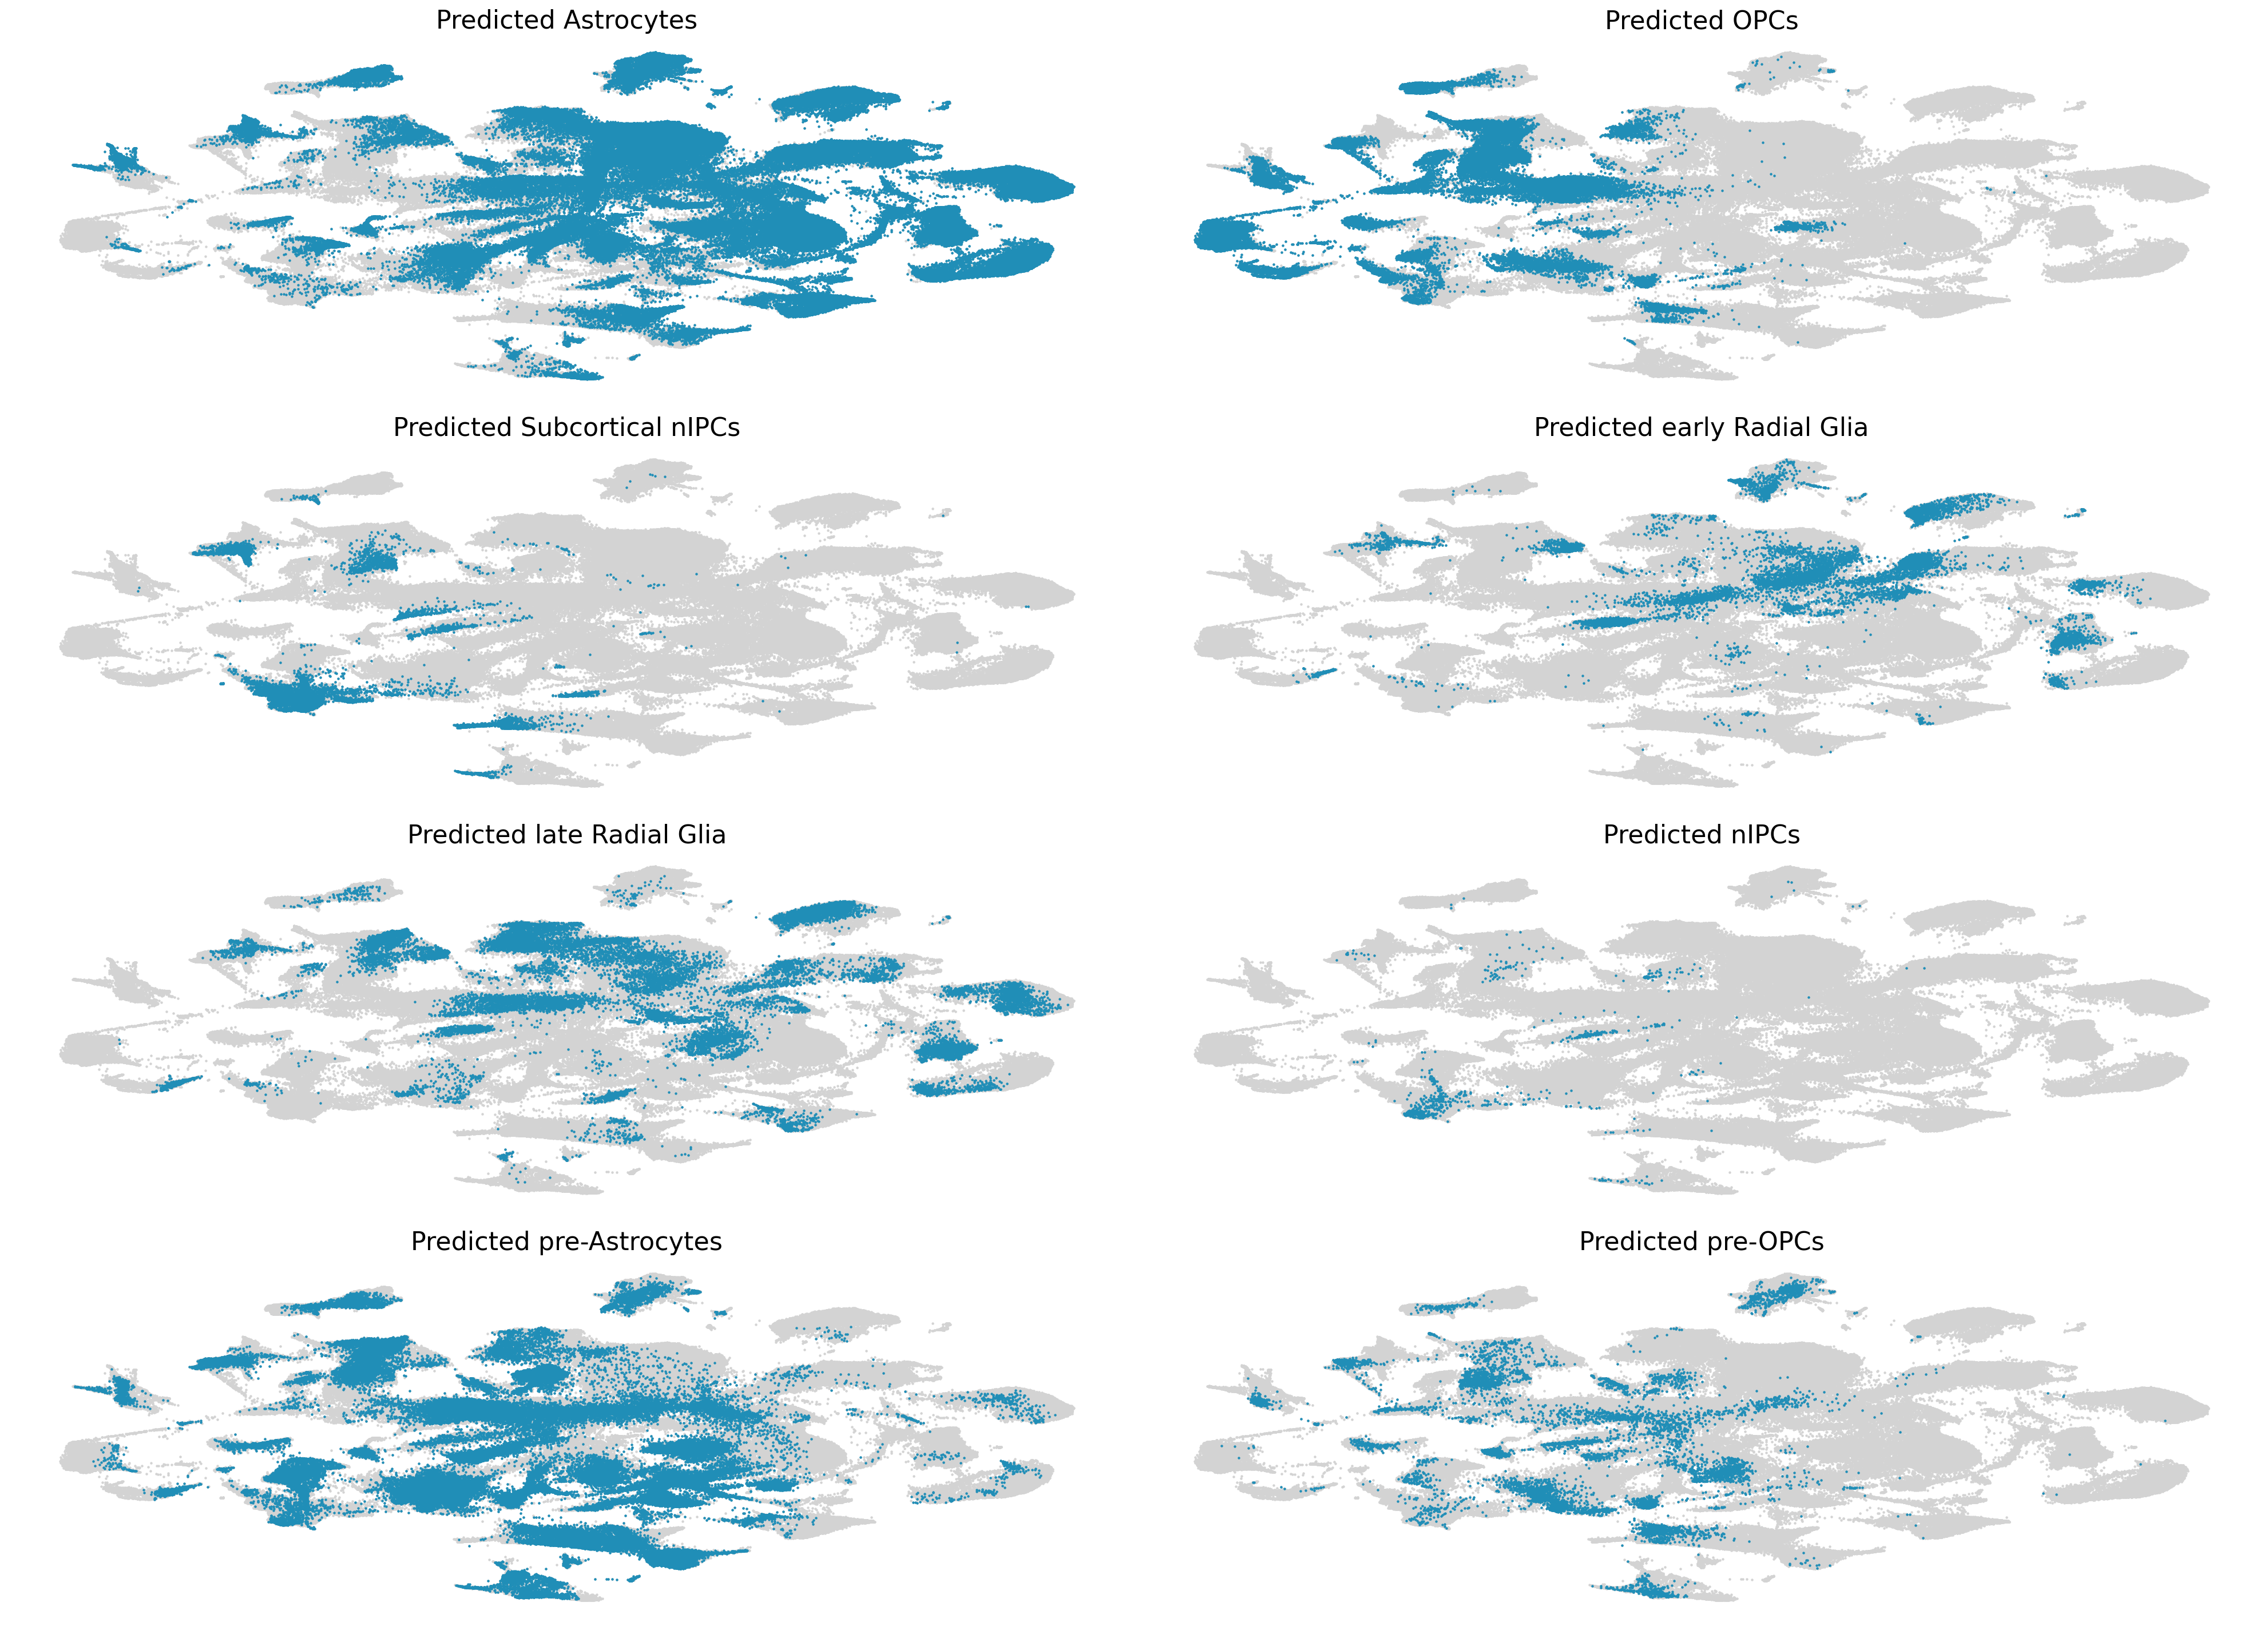

In [18]:
unique_predictions = test.obs['predictions_RF'].unique()
n_rows = (len(expected_classes) + 1) // 2
n_cols = 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(25, 18))  
axs = axs.flatten()  

for i, prediction in enumerate(expected_classes):
    ax = axs[i]
    ax.scatter(test.obsm['UMAP'][:, 0], test.obsm['UMAP'][:, 1], s=1, color="lightgray", label='Other cells')
    
    is_predicted_class = test.obs['predictions_RF'] == prediction
    ax.scatter(test.obsm['UMAP'][is_predicted_class, 0], test.obsm['UMAP'][is_predicted_class, 1], s=1, color='#208eb7', label=f'Predicted {prediction}')
    
    ax.set_title(f'Predicted {prediction}', fontsize=20)
    ax.axis('off')

plt.tight_layout()
plt.show()

#plt.savefig('rf_classification_plot.png', dpi = 600)

#### This function computes and prints the total number of cells along with a summary DataFrame that shows the count and percentage of cells for each class in predictions_RF.

In [15]:
def summarize_cell_classes(test, class_column='predictions'):
    class_counts = test.obs[class_column].value_counts()
    
    total_cells = len(test.obs)
    class_percentages = (class_counts / total_cells) * 100
    
    summary_df = pd.DataFrame({
        'Count': class_counts,
        'Percentage': class_percentages
    })
    
    print(total_cells)
    print(summary_df)

summarize_cell_classes(test, 'predictions_RF')

332357
                    Count  Percentage
predictions_RF                       
Astrocytes         145953   43.914526
pre-Astrocytes      87820   26.423394
OPCs                46839   14.092978
late Radial Glia    21312    6.412382
early Radial Glia   10911    3.282916
pre-OPCs            10008    3.011220
Subcortical nIPCs    8740    2.629702
nIPCs                 774    0.232882


#### Step 5: extracting important genes for the classifier.
This function converts a multi-class problem into a binary one by labeling each training and test instance as either the target label or "No_" plus the target label. It then trains a Random Forest classifier using these binary labels, extracts and sorts the feature importances to identify the top 25 important genes, and finally returns the top genes (both as a DataFrame and a list), the classifier’s test accuracy, and the trained classifier itself.
The comments in the chunks explain in details how the code works.

In [16]:
def find_label_genes(label):

      # --- Create binary target labels ---
    # For each example in y_train and y_test, assign the given label if it matches;
    # otherwise, mark it as "No_<label>". This converts multi-class labels into a binary problem.
    
    class_label = label
    y_train_specific = [class_label if label==class_label else 'No_' + class_label for label in y_train]
    y_test_specific = [class_label if label==class_label else 'No_' + class_label for label in y_test]

        # --- Train a Random Forest classifier ---
    # Initialize a RandomForestClassifier() and train it using the training data (x_train)
    # and the newly created binary targets (y_train_specific).

    classifier_specific = RandomForestClassifier(max_depth=40, min_samples_leaf=2, n_estimators=400, class_weight='balanced', n_jobs=-1)
    classifier_specific.fit(x_train, y_train_specific)

        # --- Extract and sort feature importances ---
    # Retrieve the importance of each gene from the trained classifier.
    # Combine these importances with the corresponding gene names (from 'selectedGenes') into a DataFrame,
    # then sort the DataFrame in descending order so that the most important genes come first.

    feature_importances_specific = classifier_specific.feature_importances_
    importances_df_specific = pd.DataFrame({
    'Gene': selectedGenes,
    'Importance': feature_importances_specific
    })
    importances_df_specific = importances_df_specific.sort_values(by='Importance', ascending=False)

        # --- Identify top 25 genes and evaluate classifier accuracy ---
    # Extract the top 25 most important genes as a list.
    # Compute the accuracy of the classifier on the test set using the binary targets (y_test_specific).
    
    first25ImportantGenes = importances_df_specific.iloc[0:25, 0].tolist()
    accuracyClassifierSpecific = classifier_specific.score(x_test, y_test_specific)

        # --- Return results ---
    # The function returns:
    # 1. A DataFrame with the top 25 genes and their importance scores.
    # 2. The list of the top 25 gene names.
    # 3. The accuracy of the classifier on the test data.
    
    return importances_df_specific.head(25), first25ImportantGenes, accuracyClassifierSpecific

#### Here the results.

In [17]:
important_genes_by_label = {}
for label in unique_predictions:
    top_genes, first25ImportantGenes, accuracy = find_label_genes(label)
    important_genes_by_label[label] = first25ImportantGenes

    print(label, '\n', top_genes, '\n', 'Accuracy:', accuracy)
print(important_genes_by_label)

Astrocytes 
           Gene  Importance
266    SPARCL1    0.087733
19        AQP4    0.067892
134      GLIS3    0.062820
17        APOE    0.060356
198      NEAT1    0.049527
284        TNC    0.043933
254     SLC4A4    0.040811
84        CST3    0.032769
86       DAAM2    0.025884
28      ATP1A2    0.021877
187     MGAT4C    0.021149
191       MMD2    0.020826
139       GRM3    0.020541
132       GJA1    0.020517
64         CLU    0.019424
180      LRIG1    0.018884
177  LINC00609    0.014852
1       ABLIM1    0.011715
205       NPNT    0.011697
11         AGT    0.011571
275      STMN1    0.010724
131       GFAP    0.009460
27     ATP13A4    0.009391
217     PCDH15    0.009168
255    SLC6A11    0.008953 
 Accuracy: 0.9795264623955432
OPCs 
         Gene  Importance
217   PCDH15    0.113006
215    OPCML    0.080890
287      TNR    0.076005
38      CA10    0.073061
211    NXPH1    0.053374
83     CSMD3    0.050616
120    FGF14    0.038323
68     CNTN1    0.036475
185    MDGA2    0.0349